In [2]:
# !poetry run pip install -U git+https://github.com/ichko/aesthetic-tensor

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML
import mediapy as mpy
import os

In [4]:
from aesthetic_tensor import monkey_patch_torch
monkey_patch_torch()

In [5]:
from nca.utils import conv_same

In [6]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 3
        hid = 128
        self.chans = 16

        self.seed = nn.Parameter(torch.rand(self.chans, 64, 64) * 2 - 1)
        self.kernel = nn.Sequential(
            nn.Dropout2d(p=0.1),
            conv_same(self.chans, perc * self.chans, ks=5, bias=True, padding_mode="circular"),
            nn.BatchNorm2d(perc * self.chans),
        )
        
        sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])/8
        sobel_y = torch.tensor([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]])/8
        identity = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
#         lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

        all_filters = torch.stack((identity, sobel_x, sobel_y))
        all_filters_batch = all_filters.repeat(self.chans, 1, 1).unsqueeze(1)
        self.all_filters_batch = nn.Parameter(all_filters_batch, requires_grad=False)
        
        self.rule = nn.Sequential(
            conv_same(perc * self.chans, hid, ks=1, bias=True),
            nn.ReLU(),
            conv_same(hid, self.chans, ks=1, bias=False),
        )

#         for p in self.kernel.parameters():
#             nn.init.normal_(p)
#         for p in list(self.rule.parameters()):
#             nn.init.normal_(p)
#         nn.init.zeros_(self.rule[-1].bias)
        nn.init.zeros_(self.rule[-1].weight)

    def forward(self, x, steps=1):
        seq = [x]
        device = next(self.parameters()).device
        for i in range(steps):
            old_x = x
#             x *= 1 + (torch.rand_like(x) - 0.5) / 25
#             x = x + (torch.rand_like(x) - 0.5) / 10
#             x = self.kernel(x)
#             x = x + self.seed
            x = F.conv2d(
                F.pad(x, (1, 1, 1, 1), "circular"),
#                 F.pad(x, (1, 1, 1, 1), "constant", 0),
                self.all_filters_batch,
                stride=1,
                padding=0,
                groups=self.chans,
            )
            x = self.rule(x)
            x = old_x + x
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [8]:
import torchsummary

In [9]:
nca = SimpleNCA()

In [10]:
S = 64
inp1 = torch.rand(2, nca.chans, S, S) * 2 - 1
inp2 = torch.zeros(1, nca.chans, S, S)
inp2[0, 0, 32, 32] = 1

inp3 = torch.ones(1, nca.chans, S, S)
inp3[0, 0, 32, 32] = 0

inp = torch.cat([inp1, inp2, inp3])

out = nca(inp, steps=50)
out.ae

float32<4, 51, 16, 64, 64>∈[-1.000, 1.000] | μ=0.251, σ=0.594

In [11]:
torchsummary.summary(nca.to("cuda"), input_size=inp1.size()[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           6,272
              ReLU-2          [-1, 128, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           2,048
Total params: 8,320
Trainable params: 8,320
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 8.50
Params size (MB): 0.03
Estimated Total Size (MB): 8.78
----------------------------------------------------------------



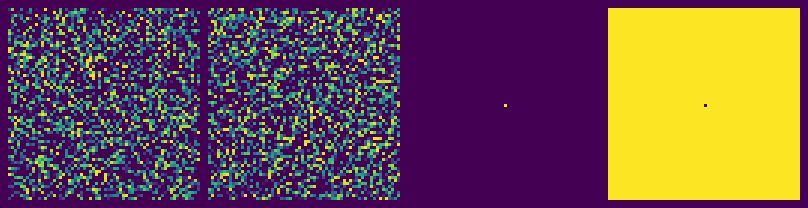

In [12]:
out.ae.zoom(3).grid(ncols=4, pad=4)[:, 0].gif(fps=24)

In [13]:
out.ae

float32<4, 51, 16, 64, 64>∈[-1.000, 1.000] | μ=0.251, σ=0.594

In [14]:
# hist_anim = torch.stack([fast_hist(out[3, i]) for i in range(200)])
# hist_anim.ae.zoom(2).cmap("binary").gif(fps=24)

In [15]:
single = out[1,:,0]
vals = single.reshape(single.shape[0], -1).sum(axis=1)
vals = vals.detach().cpu().numpy()
# plt.plot(vals)

In [16]:
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchdata.datapipes.iter import IterableWrapper

In [17]:
num_classes = 10

In [18]:
import cv2

S = 64
screen = np.zeros((S, S))

for i, tau in enumerate(np.linspace(0, np.pi * 2, num_classes, endpoint=False)):
    sr = 10
    r = 25

    x1 = S // 2 + int(np.cos(tau) * sr)
    y1 = S // 2 + int(np.sin(tau) * sr)
    x2 = S // 2 + int(np.cos(tau) * r)
    y2 = S // 2 + int(np.sin(tau) * r)
    cv2.line(screen, [x1, y1], [x2, y2], color=1, thickness=2)

explode_screen = torch.tensor(screen, dtype=torch.float32)
explode_screen.ae.zoom(3).img

In [19]:
import cv2

S = 64
screen = np.zeros((S, S))

for i, tau in enumerate(np.linspace(0, np.pi * 2, num_classes, endpoint=False)):
    sr = 8
    r = 27
    x = S // 2 + int(np.cos(tau) * r)
    y = S // 2 + int(np.sin(tau) * r)
    cv2.circle(screen, [x,  y], sr, i + 1, thickness=-1)
    
    
    x1 = S // 2 + int(np.cos(tau) * sr)
    y1 = S // 2 + int(np.sin(tau) * sr)
    x2 = S // 2 + int(np.cos(tau) * r)
    y2 = S // 2 + int(np.sin(tau) * r)
#     cv2.line(screen, [x1, y1], [x2, y2], color=i + 1, thickness=2)

#     cv2.circle(screen, [x,  y], sr * 3 - i * 3, i + 1, thickness=-1)
#     cv2.polylines(screen, [[x, y], [x]])

screen = torch.tensor(screen)
(screen / 10).ae.zoom(3).img

In [20]:
ds = MNIST(root="./.data", download=True, transform=ToTensor(), train=True)

In [21]:
bs = 32
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=True)

/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/graph_settings.py:90: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [22]:
batch = next(iter(dl))

In [23]:
def iter_input(dl):
    it = iter(dl)
    for x, y in it:
        bs, _, H, W = x.shape
        ws = 64
        s = x.shape[-1]
        digit_screen = torch.zeros(bs, nca.chans, ws, ws)
        f = ws//2 - s//2
        digit_screen[:, :3, f:f+s, f:f+s] = x
        t = (screen.unsqueeze(0) == y.unsqueeze(1).unsqueeze(1) + 1).to(torch.float32)
        yield digit_screen, y, t

In [24]:
gen = iter_input(dl)
xs = []
ts = []
ys = []
for i in range(10):
    batch = next(gen)
    x, y, t = batch
    for i in range(x.shape[0]):
        xs.append(x[i][0])
        ys.append(y[i].item())
        ts.append(t[i])
        
valid_xs = []
valid_ts = []
for i in range(10):
    i_index = (np.array(ys) == i).argmax()
    valid_xs.append(xs[i_index])
    valid_ts.append(ts[i_index])
    
torch.cat([
    torch.stack(valid_xs),
    torch.stack(valid_ts)
]).ae.zoom(2).cmap("viridis", dim=1).grid(ncols=10)[:3].img

In [25]:
gen = iter_input(dl)
batch = next(gen)
x, y, t = batch
x[:16].ae.zoom(2).grid()[0].img

In [26]:
(t[:16]).ae.zoom(2).grid().img

In [27]:
batch[0].ae

float32<32, 16, 64, 64>∈[0.000, 1.000] | μ=0.004, σ=0.062

In [28]:
out = nca.to("cpu")(batch[0], steps=40)

In [29]:
# out[:16].ae.zoom(2).grid(ncols=8, pad=2)[:, 0].gif(fps=10)

In [30]:
torch.stack(
    [torch.tensor(screen == i) for i in range(num_classes + 1)]
).to(float).ae.zoom(3).grid(ncols=num_classes + 1).img

/tmp/ipykernel_2314099/547381105.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(screen == i) for i in range(num_classes + 1)]


In [32]:
clf_out = torch.stack([
    out[:, -5:, 0].mean(axis=1)[:, screen == s + 1].mean(axis=1)
    for s in range(len(np.unique(screen)) - 1)
], axis=1)

In [33]:
# torch.softmax(clf_out, dim=-1)

In [36]:
out[:, 32:34, 0].abs().mean(axis=[1]).ae

float32<32, 64, 64>∈[0.000, 1.000] | μ=0.024, σ=0.141

In [52]:
def optim_step(i, nca, batch, optim, device, grad_clip_val=0.1):
    x, y, t = batch
    x = x.to(device)
    y = y.to(device)
    t = t.to(device)
    bs = x.shape[0]
    out = nca(x, steps=np.random.randint(60, 80))
    last = np.random.randint(1, 5)

    clf_out = torch.stack([
        out[:, -last:, 0].mean(axis=1)[:, screen == s + 1].mean(axis=1)
        for s in range(len(np.unique(screen)) - 1)
    ], axis=1)
    clf_loss = F.cross_entropy(clf_out, y)

#     target_out = out[:, -last:, 0].abs().mean(axis=[1])
    target_out_mid = out[:, 32:34, 0].abs().mean(axis=[1])

    explosion_loss = F.mse_loss(target_out_mid, explode_screen.unsqueeze(0).repeat(bs, 1, 1).to(device))
    loss = clf_loss / 10 # F.mse_loss(target_out, t)
    loss += explosion_loss

    optim.zero_grad()
    loss.backward()
#     torch.nn.utils.clip_grad_norm_(nca.parameters(), grad_clip_val)
    optim.step()
    
    return loss, out, clf_loss, explosion_loss

In [65]:
explode_screen.unsqueeze(0).ae

float32<1, 64, 64>∈[0.000, 1.000] | μ=0.127, σ=0.333

In [42]:
from copy import deepcopy

In [43]:
lr = 0.0001
target_nca = deepcopy(nca)
history = []

In [44]:
with open("save-exploding.pkl", "rb") as fp:
    target_nca = torch.load(fp)

In [45]:
optim = torch.optim.Adam(target_nca.parameters(), lr=lr)

In [46]:
device = "cuda"
target_nca = target_nca.to(device)

In [47]:
# _, _, clf, expl = optim_step(i, target_nca, batch, optim, device)

In [48]:
torch.autograd.set_detect_anomaly(True)

In [73]:
# target_nca.kernel[0].padding_mode = "circular"

In [74]:
# !rm -rf checkpoints/

In [75]:
save_dir = "checkpoints2"
os.makedirs(save_dir, exist_ok=True)

In [76]:
!du -h checkpoints2

51M	checkpoints2


In [77]:
import pickle
# with open("hist.pkl", "wb+") as fp:
#     pickle.dump(history, fp)

# with open("hist.pkl", "rb") as fp:
#     history = pickle.load(fp)

In [51]:
from IPython.display import clear_output
pbar = tqdm(range(0, 80000 + 10_000))

for i in pbar:
    try:
        batch = next(gen)
    except StopIteration as err:
        gen = iter_input(dl)
        continue
    loss, out, _, _ = optim_step(i, target_nca, batch, optim, device)
    pbar.set_description(f"Loss: {loss:.10f}")
    history.append(loss.item())

    if i % 250 == 0:
        clear_output(wait=True)
        display(pbar.container)
        plt.plot(history)
        plt.yscale("log")
        plt.show()

        with torch.no_grad():
            gif = out[:16].ae.zoom(2).grid(ncols=8, pad=2)[:, 0].gif(fps=24)
            display(gif)
            
            with open(os.path.join(save_dir, f"model-{i:05}-Lf{loss.item():0.6f}.pkl"), "wb+") as fp:
                torch.save(target_nca, fp)

  0%|          | 0/90000 [00:00<?, ?it/s]

NameError: name 'optim_step' is not defined

In [50]:
loss, out, _, _ = optim_step(i, target_nca, batch, optim, device)

NameError: name 'optim_step' is not defined


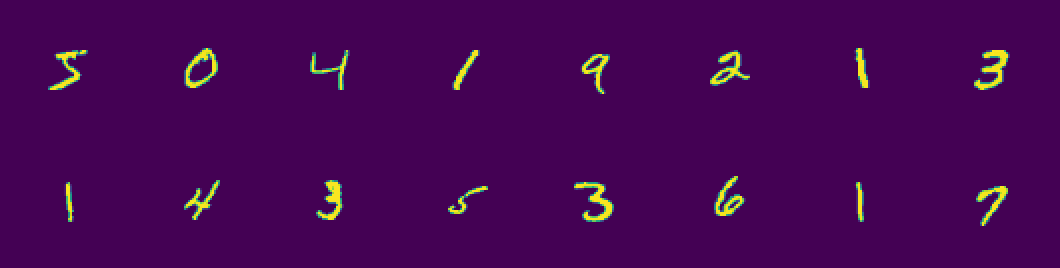

In [49]:
gif = out[:16].ae.zoom(2).grid(ncols=8, pad=2)[:, 0].gif(fps=24)
gif

In [122]:
import gc
def clean_mem():
    torch.cuda.empty_cache()
    gc.collect()
    
clean_mem()

In [123]:
checkpoint_names = os.listdir("./checkpoints2/")
losses = [float(c.split("Lf")[1].split(".pkl")[0]) for c in checkpoint_names]

ml = min(losses)
min_loss_checkpoint_name = [c for c in checkpoint_names if str(ml) in c][0]
min_loss_nca = torch.load(f"./checkpoints2/{min_loss_checkpoint_name}")

min_loss_checkpoint_name

'model-77500-Lf0.039425.pkl'

In [126]:
target_nca = min_loss_nca

In [127]:
device = "cuda"

In [376]:
train_ds = MNIST(root="./.data", download=True, transform=ToTensor(), train=False)
bs = 64
dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
preds = []
actuals = []
for batch in tqdm(iter_input(dl), total=len(train_ds) // bs):
    x, ys, t = batch
    x = x.to(device)
    with torch.inference_mode():
        outs = target_nca.to(device)(x, steps=80)
        for out, y in zip(outs, ys):
            last_frame = out[-1, 0]
            pred_class = torch.stack([last_frame[screen == i].mean() for i in range(1, 11)]).argmax()
#             print(pred_class, y)

            preds.append(pred_class.item())
            actuals.append(y.item())

  0%|          | 0/156 [00:00<?, ?it/s]

In [377]:
preds = np.array(preds)
actuals = np.array(actuals)

In [378]:
from sklearn.metrics import ConfusionMatrixDisplay

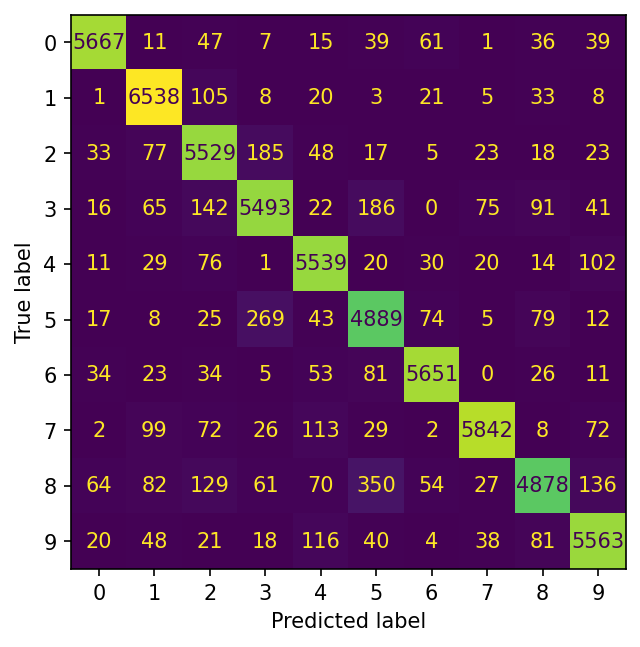

In [375]:
fig, ax = plt.subplots(dpi=150)
ConfusionMatrixDisplay.from_predictions(actuals, preds, colorbar=False, ax=ax)

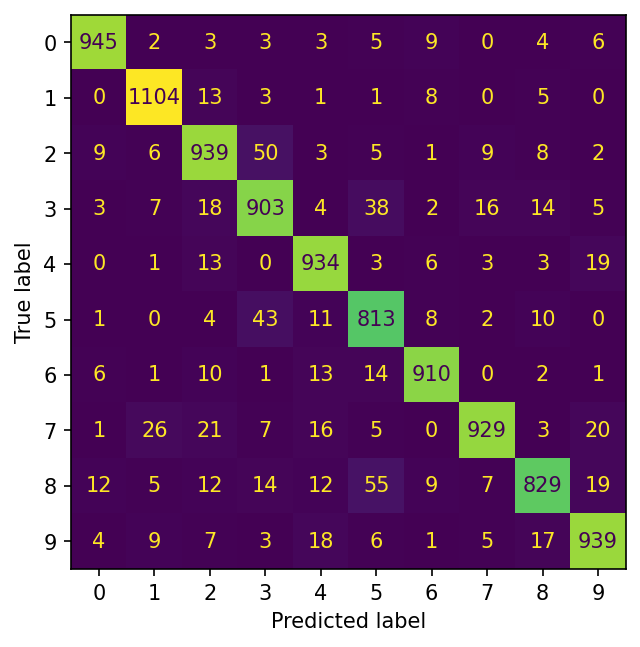

In [379]:
fig, ax = plt.subplots(dpi=150)
ConfusionMatrixDisplay.from_predictions(actuals, preds, colorbar=False, ax=ax)

In [370]:
(actuals == preds).sum() / len(preds)

0.9264833333333333

In [365]:
(actuals == preds).sum() / len(preds)

0.9245

In [392]:
cls_outs = {}
with torch.inference_mode():
    for i in tqdm(range(10)):
        batch = next(gen)
        x, y, t = batch
        t = t.to("cuda")
        out = target_nca.eval().to("cuda")(x.to("cuda"), steps=90)
        for cls in range(num_classes):
            cls_mask = y.to("cuda") == cls
            cls_out = out[cls_mask]
            cls_outs.setdefault(cls, []).append([cls_out, t[cls_mask]])

  0%|          | 0/10 [00:00<?, ?it/s]

In [393]:
num_outs = []
for cls in range(num_classes):
    max_val = -1
    max_id = -1
    max_out = None
    for outs, t in cls_outs[cls]:
        if outs.shape[0] == 0:
            continue
        vals = -((outs[:, -1, 0] - t) ** 2).mean([1, 2])
        argmax = vals.argmax()
        if vals[argmax] > max_val:
            max_val = vals[argmax]
            max_id = argmax
            max_out = outs[argmax]

    num_outs.append(max_out)

num_outs = torch.stack(num_outs)
num_outs.ae

float32<10, 91, 16, 64, 64>∈[-13.782, 10.856] | μ=-0.190, σ=1.028

In [214]:
num_outs[0:10, [0, 10, 20, 30, 40, 50, -30], 0].ae.cmap("viridis", dim=-3)\
    .grid(ncols=10, pad=0).grid(ncols=1, pad=0)[:3].img

In [333]:
num_outs[1, [0, 10, 20, 30, 40, 50, -30]][:, [0,3,4,11,13,15]].ae.grid(ncols=7).grid(ncols=1).zoom(1).img

In [334]:
torch.cat([
    num_outs[:, :1].repeat((1, 20, 1, 1, 1)),
    num_outs,
], dim=1).ae.zoom(3).grid(ncols=10, pad=2)[:, 0]

float32<131, 200, 1964>∈[-0.438, 1.506] | μ=0.063, σ=0.183

In [335]:
vid = torch.cat([
    num_outs[:, :1].repeat((1, 20, 1, 1, 1)),
    num_outs,
], dim=1).ae.zoom(1).grid(ncols=3, pad=2)

In [336]:
vid.raw.shape

(131, 16, 276, 208)

In [339]:
# mpy.show_video(vid.raw[:, :3], fps=60, border=True)

In [400]:
paused = torch.cat([
    num_outs[:, :1].repeat((1, 40, 1, 1, 1)),
    num_outs,
#     num_outs[:, -1:].repeat((1, 20, 1, 1, 1)),
], dim=1)

In [397]:
paused.ae

float32<10, 151, 16, 64, 64>∈[-13.782, 10.856] | μ=-0.141, σ=0.854

In [340]:
hid_vid = paused.permute(0, 2, 1, 3, 4)[:,[0,1,3,8,9,10,11,12,13,14]].ae \
    .grid(ncols=1).grid(ncols=10).zoom(1).cmap("viridis")[:, :, :, :3]

In [341]:
hid_vid

uint8<171, 666, 702, 3>∈[1.000, 253.000] | μ=65.572, σ=55.359

In [342]:
# mpy.show_video(hid_vid.raw, fps=60, border=True)

In [394]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan',
]

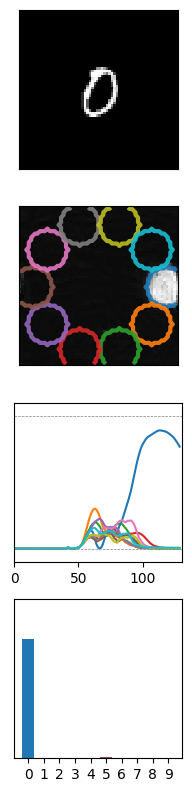

In [418]:
def plot_fun(out, frame_id=-1, batch_id=0):
    f = frame_id
    b = batch_id
    out = out.detach().cpu()
    bs, L, _, H, W = out.shape
    im = out[b, f, 0]

    vals_list = []
    for cls in range(num_classes):
        vals = out[b, :f, 0][:, screen == cls + 1].mean(axis=-1)
        vals_list.append(vals)

    bar_vals_list = []
    for cls in range(num_classes):
        bar_vals = out[b, f, 0][screen == cls + 1].mean(axis=-1)
        bar_vals_list.append(bar_vals)
    bar_vals = torch.stack(bar_vals_list)

    fig, axs = plt.subplots(4, 1, figsize=(2, 8), dpi=100)
    axs[0].imshow(out[b, 0, 0], interpolation='none', aspect="auto", cmap="Greys_r")
    axs[1].imshow(out[b, frame_id, 0], interpolation='none', aspect="auto", cmap="Greys_r")

    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
#     axs[1].set_xticks([])
    axs[3].set_xticks([])
    axs[1].set_yticks([])
    axs[2].set_yticks([])
    axs[3].set_yticks([])

    for cls in range(num_classes):
        c = colors[cls]
        axs[1].contour(screen == cls + 1, colors=c, linewidths=3, alpha=0.9)
        axs[2].plot(vals_list[cls], c=c)
        axs[3].bar(range(num_classes), bar_vals, color=colors[:num_classes])

    axs[0].set_aspect(1)
    axs[1].set_aspect(1)
    axs[2].axhline(1, color="tab:grey", linestyle="--", linewidth=0.5)
    axs[2].axhline(0, color="tab:grey", linestyle="--", linewidth=0.5)
    axs[2].set_xlim(0, L)
    axs[2].set_ylim(-0.1, 1.1)

    axs[3].set_ylim(0, 1)
    axs[3].set_xticks(range(num_classes))

    plt.tight_layout(pad=1)

    plt.close()
    return fig

plot_fun(paused, -1, 0)

In [419]:
L = paused.shape[1]
figs_list = []
for cls in tqdm(range(num_classes)):
    figs = [plot_fun(paused, i, cls) for i in tqdm(range(0, L))]
    figs_list.append(figs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

In [420]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches="tight", pad_inches=0.1)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [421]:
pils_list = []
for figs in tqdm(figs_list):
    pils = [fig2img(f) for f in tqdm(figs)]
    pils_list.append(pils)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

In [422]:
# pils_list[0][-1]

In [423]:
cat_pils = [
    Image.fromarray(
        np.concatenate([
            np.concatenate([np.array(ps[frame_id]) for ps in pils_list[:10]  ], axis=1),
#             np.concatenate([np.array(ps[frame_id]) for ps in pils_list[5:10]], axis=1)
        ], axis=0)
    ) for frame_id in tqdm(range(len(pils_list[0])))
]

  0%|          | 0/131 [00:00<?, ?it/s]

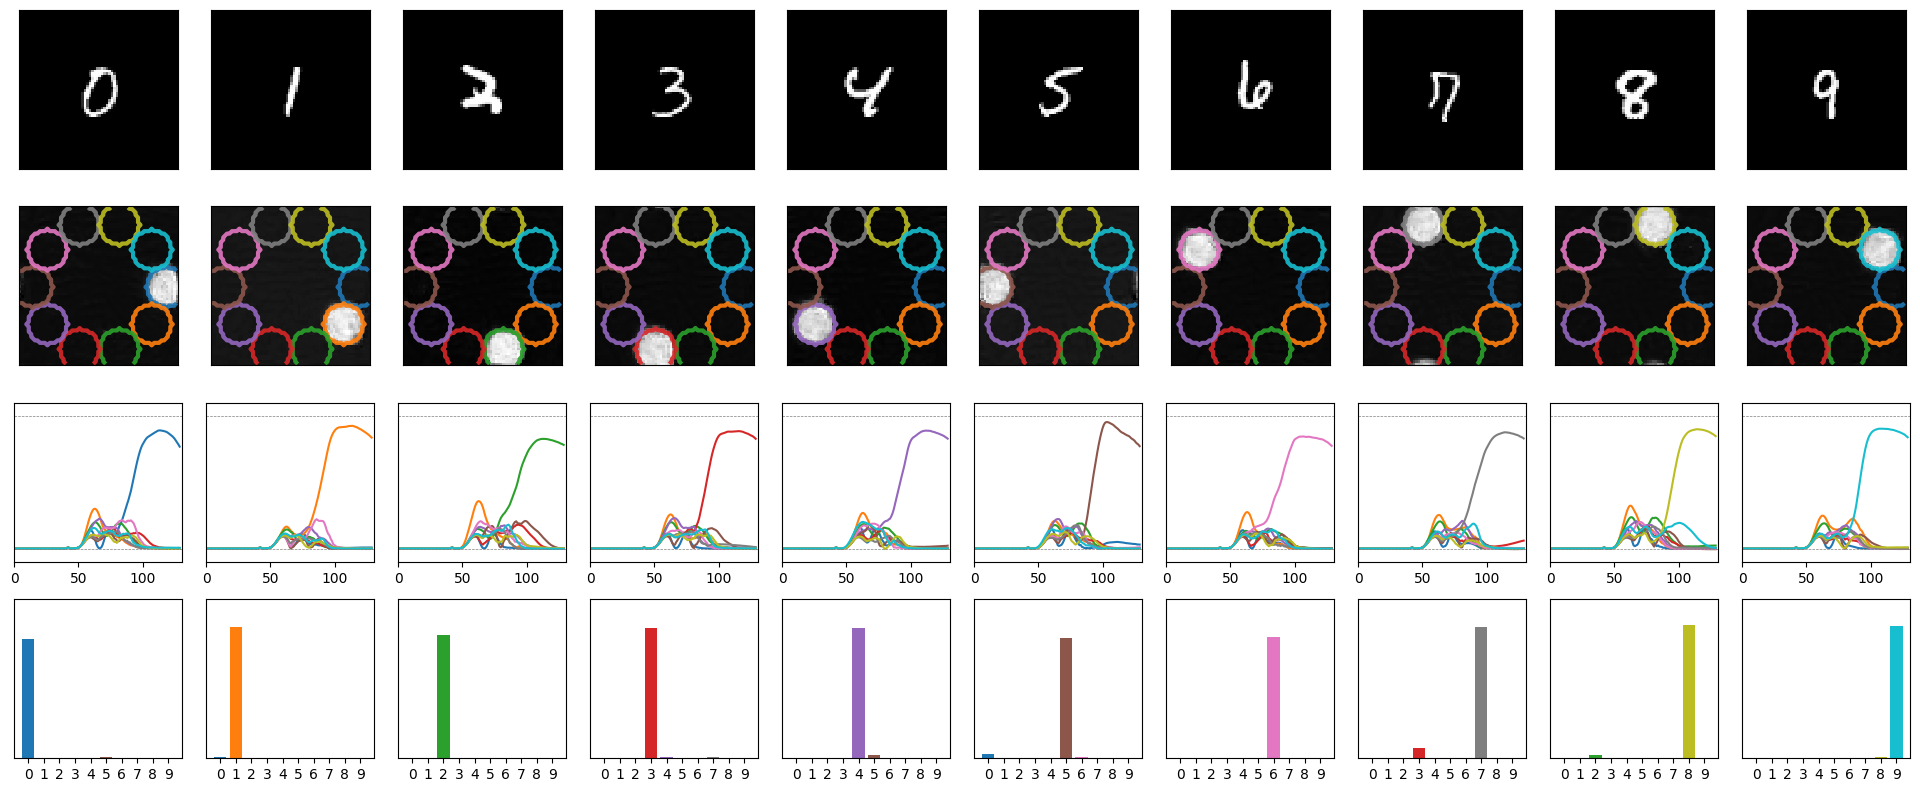

In [426]:
cat_pils[-1]

In [424]:
import numpy as np

image_stack = np.ones((2, 2, 18))

extra_left, extra_right = 1, 2
extra_top, extra_bottom = 3, 1

np.pad(image_stack, ((extra_top, extra_bottom), (extra_left, extra_right), (0, 0)),
       mode='constant', constant_values=3).shape

(6, 5, 18)

In [425]:
def rescale_pil(pil, scale=1):
    W, H = pil.size
    new_W, new_H = int(W * scale), int(H * scale)
    return pil.resize((new_W, new_H))

In [229]:
rescale_pil(cat_pils[0], scale=0.9).size

(172, 532)

In [230]:
def gif_from_pils(pils, fps):
    pils = [rescale_pil(p, scale=0.9) for p in pils]
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [231]:
len(cat_pils)

171


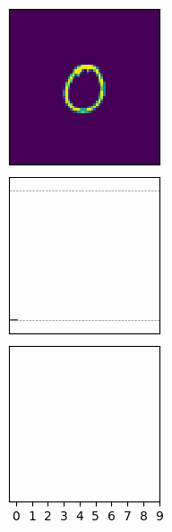

In [232]:
gif_from_pils(cat_pils[10:], fps=30)

In [ ]:
from flask import Flask, render_template, Response, request
import multiprocessing
import cv2
import numpy as np

In [ ]:
app = Flask(__name__)

In [ ]:
def gen_frames():  
    while True:
        frame = np.random.randint(0, 255, size=(100, 100, 3), dtype=np.uint8)
        ret, buffer = cv2.imencode('.jpg', frame)
        frame = buffer.tobytes()
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')  # concat

In [ ]:
@app.route('/video_feed')
def video_feed():
    return Response(gen_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

In [ ]:
def shutdown_server():
    func = request.environ.get('werkzeug.server.shutdown')
    if func is None:
        raise RuntimeError('Not running with the Werkzeug Server')
    func()
    
@app.get('/shutdown')
def shutdown():
    shutdown_server()
    return 'Server shutting down...'

In [ ]:
def run():
    app.run(debug=False, port=8789)

In [ ]:
import threading
# t = threading.Thread(target=run)
t = multiprocessing.Process(target=run)

In [ ]:
t.start()

In [ ]:
t.terminate()

In [ ]:
%%html
<img src="http://localhost:8789/video_feed"/>

In [ ]:
%%javascript

